In [2]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from matplotlib import pyplot as plt
from roman_imsim.utils import roman_utils
from roman_imsim import *
import astropy.table as tb
import warnings 
from astropy.utils.exceptions import AstropyWarning
from erfa import ErfaWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.filterwarnings("ignore", category=ErfaWarning)
import scipy.sparse as sp 
from scipy.linalg import block_diag, lstsq
from numpy.linalg import LinAlgError
from astropy.nddata import Cutout2D
from coord import *
import requests
from astropy.table import Table
import os
import scipy
import time
import galsim

import sklearn
from sklearn import linear_model
from scipy.interpolate import RectBivariateSpline

roman_path = '/hpc/group/cosmology/OpenUniverse2024'
sn_path = '/hpc/group/cosmology/OpenUniverse2024/roman_rubin_cats_v1.1.2_faint/'

'''
Cole Meldorf 2024
Adapted from code by Pedro Bernardinelli

                    ___                         
                   / _ \___  __ _  ___ ____     
                  / , _/ _ \/  ' \/ _ `/ _ \    
                 /_/|_|\___/_/_/_/\_,_/_//_/    
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⣔⣴⣦⣔⣠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣼⣿⣭⣿⣟⣿⣿⣿⣅⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣾⣷⣾⣿⣿⣿⣿⣿⣿⣿⡶⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣄⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⠄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣠⠤⢤⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⢒⣿⣿⣿⣠⠋⠀⠀⠀⠀⠀⠀⣀⣀⠤⠶⠿⠿⠛⠿⠿⠿⢻⢿⣿⣿⣿⠿⠟⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⡞⢀⣿⣿⣿⡟⠃⠀⠀⠀⣀⡰⠶⠛⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠃⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠘⢧⣤⣈⣡⣤⠤⠴⠒⠊⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀


                 _____  __     ___  __________
                / __/ |/ /    / _ \/  _/_  __/
               _\ \/    /    / ___// /  / /   
              /___/_/|_/    /_/  /___/ /_/    
                                
                                                        
'''

from AllASPFuncs import *

In [3]:
biases = []
stds = []


roman_bandpasses = galsim.roman.getBandpasses()


###################### BEGIN TEST PARAMETERS #######################
band = 'Y106'
npoints = 7
size = 11     #Stampsize of the image used
testnum = 10 #Total number of images
detim = 5 #Number of images with a supernova

use_real_images = False
use_roman = False  #Use a Roman PSF

# These are only for my simulated images # 
#These 5 options are a sanity check. If flipped all to true, the code should be able to perfectly recover the input.
check_perfection = False   
make_exact = False                            
avoid_non_linearity = False         #The PSF does not scale perfectly linearly. This cheats by making the SN model point have a flux equal to that of the 
                                    #SN, rather than giving it a flux of 1 and scaling the SN flux by the fit value. Therfore a perfect fit will recover
                                    # a value of 1.00000
deltafcn_profile =  False           #This is a check to see if the code can recover the input when the input is a delta function.
single_grid_point = False           #This cheats and makes the grid only one point, which is the location of the bg galaxy.

#PSF for when not using the Roman PSF:
lam = 1293  # nm
lam_over_diam = 0.11300864172775239   #This is the roman value
airy = galsim.ChromaticOpticalPSF(lam, diam = 2.36, aberrations=galsim.roman.getPSF(1,band, pupil_bin = 1).aberrations)
#util_ref = roman_utils(config_file='./temp_tds.yaml', visit = 502, sca = 13)
#airy = util_ref.getPSF()
#airy = galsim.roman.getPSF(13, band, pupil_bin=8)

do_xshift = True    #whether to shift the images in the x direction (they will still be centered on the same point, this is just to emulate\
        #Roman taking a series of images at different locations.)
do_rotation = True #whether to rotate the images
noise = 0 #Standard Deviation of noise to add to a simulated image. 
background_level = 0  #mean of the noise to add to the image
if detim == 0:
    supernova = 0
else:
    d = np.linspace(5,20,detim)
    mags = -5 * np.exp(-d/10) + 6
    mags = mags[::-1]
    print('flipping LC as a test')
    fluxes = 10**(mags)
    supernova = list(fluxes)   #This is my faux lightcurve, you can edit this if you want to test with a different lightcurve.
#########################################

method = 'lsqr'  #The method to use to fit the images. Currently only 'lsqr' is supported.
make_initial_guess = True  #Make an initial guess for the grid point values by averaging over pixels
adaptive_grid = False      #Use my new adaptive grid method rather than a static evenly spaced grid. Bizarrely, this seems to be worse
                            #when just fitting background, but gives better results when fitting for the supernova flux.
spline_grid = False

fit_background = False    #If true, each image will have a new parameter introduced with it that fits for the background. If False
                            #the background will be subtracted from the images before fitting based on the background level over the whole image.
                            #So far, I've found keeping this to be False is better.

weighting = True #Apply a weighting to the fit. Currently, this is a tophat of radius 4 pix around the SN location and a 2D gaussian of width 2.5.

pixel = False  #Use a tophat profile to be convolved with the PSF, rather than delta functions. This does not seem to make a huge difference.
assert not (adaptive_grid and single_grid_point)

if make_exact:
    assert single_grid_point
if avoid_non_linearity:
    assert deltafcn_profile
assert detim <= testnum
if type(supernova) == 'list':
    assert len(supernova) == detim


galsim.roman.roman_psfs._make_aperture.clear() #clear cache

sed = galsim.SED(galsim.LookupTable([100, 2600], [1,1], interpolant='linear'),
                                wave_type='nm', flux_type='fphotons')

###################### END TEST PARAMETERS #######################

################### Finding and Preparing Images Section #########


for ID in [30666595]:
    #50134575, 50022453, 40018655, 20055347, 50027278, 50144007, 40084671, \
    #50070195, 50071618, 40120913, 50065247, 50061540, 60144043, 50118342, 50119066,\
    #     50123776, 50049302, 50010393, 40096456, 50093469, 50099064, 20170506, 30666595,30201096
    print('ID:', ID)

    #check if file exists

    #if os.path.exists(f'./results/{ID}_{band}_detections.csv'):
        #print('File exists, skipping')
        #continue

    #try:

    psf_matrix = []
    imagelist = []
    fit_sn_storage = []
    sn_matrix = []
    cutout_wcs_list = []
    im_wcs_list = []
    gridmade = False

    #This is a catch for when I'm doing my own simulated WCS's
    image = None
    util_ref = None

    '''
    for p1 in [30, 35]:
        for p2 in [75, 80, 85]:
            for p3 in [85, 90, 95]:
    '''
    #percentiles = [35, 85, 85]
    percentiles = [50, 95]
    psf_matrix = []
    imagelist = []

    sn_matrix = []
    cutout_wcs_list = []
    im_wcs_list = []


    if use_real_images:
        #Find SN Info, find exposures containig it, and load those as images. 
        images, cutout_wcs_list, im_wcs_list, err, snra, sndec, ra, dec, exposures = fetchImages(testnum, detim, ID, sn_path, band, size, fit_background)
        if len(exposures) != testnum:
                print('Not enough exposures')
                continue
        imlist = [images[i*size**2:(i+1)*size**2].reshape(size,size) for i in range(testnum)]

    else:
        #Simulate the images of the SN and galaxy.
        ra, dec = 7.541534306163982, -44.219205940734625
        snra = ra
        sndec = dec
        galra = ra + 2*1.5e-5
        galdec = dec + 2*1.5e-5


        images, im_wcs_list, cutout_wcs_list,psf_storage, sn_storage = simulateImages(testnum,detim,ra,dec,do_xshift,\
            do_rotation,supernova,noise = noise,use_roman=use_roman, size = size, band = band, input_psf = airy, deltafcn_profile = deltafcn_profile)
        imlist = [images[i*size**2:(i+1)*size**2].reshape(size,size) for i in range(testnum)]


    #If not using the adaptive grid, make a grid of points to fit over.
    print('SWITCHING TO GALRA AND GALDEC IN MAKE GRID')
    ra_grid, dec_grid = makeGrid(adaptive_grid, images,size,galra,galdec,cutout_wcs_list, single_grid_point=single_grid_point, percentiles=percentiles, npoints = npoints)

    if weighting:
        wgt_matrix = getWeights(cutout_wcs_list,size,snra,sndec, error = None)
    
    #Using the images, hazard an initial guess.
    if make_initial_guess and testnum - detim != 0:
        if supernova != 0:
            x0test = generateGuess(imlist[:-detim], cutout_wcs_list, ra_grid, dec_grid)
            x0test = np.concatenate([x0test, np.full(testnum, 3000)], axis = 0)
            print('setting initial guess to 3000')
        else:
            x0test = generateGuess(imlist, cutout_wcs_list, ra_grid, dec_grid)

    else:
        x0test = None

    ############################################### Fitting Section ###############################################


    #Calculate the Confusion Metric
    if use_real_images:
        x,y = im_wcs_list[0].toImage(ra,dec, units = 'deg')
        snx, sny = cutout_wcs_list[0].toImage(snra, sndec, units = 'deg')
        pointing = exposures['Pointing'][0]
        SCA = exposures['SCA'][0]
        array = construct_psf_source(x, y, pointing, SCA, \
                        stampsize = size, x_center = snx, y_center = sny, sed = sed)
        confusion_metric = np.dot(images[:size**2], array)
        print('Confusion Metric:', confusion_metric)




    #Build the backgrounds loop
    print('\n')
    bg_psf_storage = []
    for i in range(testnum):

        spinner = ['|', '/', '-', '\\']
        print('Constructing Model ' + str(i) + '   ' + spinner[i%4], end = '\r')
        if use_roman:
            sim_psf = galsim.roman.getPSF(1,band, pupil_bin=8, wcs = cutout_wcs_list[i])
        else:
            sim_psf = airy

        x,y = im_wcs_list[i].toImage(ra,dec, units = 'deg')

        #Build the model for the background using the correct psf and the grid we made in the previous section. 
        if use_real_images:
            util_ref = roman_utils(config_file='./temp_tds.yaml', visit = exposures['Pointing'][i], sca = exposures['SCA'][i])
        else:
            util_ref = roman_utils(config_file='./temp_tds.yaml', visit = 502, sca = 13)
        array, bg_psf = construct_psf_background(ra_grid, dec_grid, cutout_wcs_list[i],\
            x, y, size, roman_bandpasses[band], color=0.61, \
                psf = sim_psf, pixel = pixel, include_photonOps = False, util_ref = util_ref, use_roman = use_roman)
        bg_psf_storage.append(bg_psf)
        '''
        plt.figure(figsize = (5,5))
        plt.title('bg outside of the fcn')
        plt.imshow(array.reshape(size,size))
        '''
        
        '''
        if single_grid_point:
            pointx, pointy = cutout_wcs_list[i].toImage(galra, galdec, units = 'deg')
            stamp = galsim.Image(size,size,wcs=cutout_wcs_list[i])
            profile = galsim.DeltaFunction()*sed
            if avoid_non_linearity:
                fluxpoint = 5000
            else:
                fluxpoint = 1
            profile = profile.withFlux(fluxpoint, util_ref.bpass) 
            convolved = galsim.Convolve(profile, sim_psf)
            
            array = convolved.drawImage(util_ref.bpass, method='no_pixel', image = stamp, \
                        wcs = cutout_wcs_list[i], center = (pointx, pointy), \
                            use_true_center = True, add_to_image = False).array.flatten().reshape(-1,1)
        '''

        

        
        if fit_background:
            for j in range(testnum):
                if i == j:
                    bg = np.ones(size**2).reshape(-1,1)
                else:
                    bg = np.zeros(size**2).reshape(-1,1)
                array = np.concatenate([array,bg], axis = 1)
        
        #Add the array of the model points and the background (if using) to the matrix of all components of the model.
        psf_matrix.append(array)
        
        #The if statements in this section could be written much more elegantly
        if supernova != 0 and i >= testnum - detim:
            snx, sny = cutout_wcs_list[i].toImage(snra, sndec, units = 'deg')
            if use_roman:
                if use_real_images:
                    pointing = exposures['Pointing'][i]
                    SCA = exposures['SCA'][i]
                else:
                    pointing = 502
                    SCA = 13
                array = construct_psf_source(x, y, pointing, SCA, \
                        stampsize = size, x_center = snx, y_center = sny, sed = sed)
            else:
                stamp = galsim.Image(size,size,wcs=cutout_wcs_list[i])
                profile = galsim.DeltaFunction()*sed
                profile = profile.withFlux(1,roman_bandpasses[band]) 
                convolved = galsim.Convolve(profile, sim_psf)
                array = convolved.drawImage(roman_bandpasses[band], method='no_pixel', image = stamp, \
                            wcs = cutout_wcs_list[i], center = (snx, sny), \
                                use_true_center = True, add_to_image = False).array.flatten()
            fit_sn_storage.append(array)
                
            sn_matrix.append(array)


    psf_matrix = np.array(psf_matrix)
    psf_matrix = np.vstack(psf_matrix)

    matrix_list = []
    matrix_list.append(psf_matrix)


    psf_zeros = np.zeros((psf_matrix.shape[0], testnum))

    #Add in the supernova images to the matrix in the appropriate location so that it matches up with the image 
    #it represent. All others should be zero.

    if supernova != 0:
        for i in range(detim):
            psf_zeros[
                (testnum- detim + i) * size * size : (testnum - detim + i + 1) * size * size, (testnum - detim) + i
            ] = sn_matrix[i]
        sn_matrix =psf_zeros
        sn_matrix = np.array(sn_matrix)
        sn_matrix = np.vstack(sn_matrix)
        matrix_list.append(sn_matrix)


    #Combine the background model and the supernova model into one matrix.
    psf_matrix_all = np.hstack(matrix_list)
    psf_matrix = psf_matrix_all

    if weighting:
        wgt_matrix = np.array(wgt_matrix)
        wgt_matrix = np.hstack(wgt_matrix)



    #These if statements can definitely be written more elegantly.
    if not make_initial_guess:
        x0test = np.zeros(psf_matrix.shape[1])

    if fit_background:
        x0test = np.concatenate([x0test, np.zeros(testnum)], axis = 0)

    if not weighting:
        wgt_matrix = np.full_like(images, 1.0)

    #
    if method == 'lsqr':
        lsqr = sp.linalg.lsqr(psf_matrix*wgt_matrix.reshape(-1,1), images*wgt_matrix, \
                        x0 = x0test, atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)

        X, istop, itn, r1norm = lsqr[:4]
        print(istop, itn, r1norm)


    #Using the values found in the fit, construct the model images.
    pred = X*psf_matrix
    sumimages = np.sum(pred, axis = 1)
    res = sumimages - images
    biases.append(np.mean(res))
    stds.append(np.std(res))



    true_mags = -2.5*np.log10(supernova) + 14
    model_mags = -2.5*np.log10(X[-detim:]) + 14
    res = true_mags - model_mags
    biases.append(np.mean(res))
    stds.append(np.std(res))


    if check_perfection:
        if avoid_non_linearity:
            f = 1
        else:
            f = 5000
        if single_grid_point:
            X[0] = f
        else:
            X = np.zeros_like(X)
            X[106] = f
    print(percentiles, '---------------')
    print(np.size(ra_grid))
    print(biases[-1])
    print(stds[-1])
    if use_real_images:
        detections = exposures[np.where(exposures['DETECTED'])]
        detections['measured_flux'] = X[-detim:]
        detections['confusion_metric'] = confusion_metric
        df = open_parq(10430, path = sn_path)
        print(df.columns)
        detections['host_sep'] = df['host_sn_sep'][df['id'] == ID].values[0]
        detections['host_mag_g'] = df[f'host_mag_g'][df['id'] == ID].values[0]
        detections['grid points'] = np.size(ra_grid)
        detections = detections.to_pandas()
        #detections.to_csv(f'./results/{ID}_{band}_detections.csv', index = False)
        #print('Saved to ./results/' + f'{ID}_{band}_detections.csv')
        print('Saving not performed')

    '''
    except Exception as e:
        print('Failed on ID:', ID)
        print(e)
        continue
    '''

#Run method, main, main parses arguments
#If block or for block longer than 5 lines? --> function
#Save un-run notebook
#git .ignore
#tests directory
#Tests running a function and see if it returns the expected value
#Make big chunks of code into functions
#Export as python

flipping LC as a test
ID: 30666595
doubling separation
ra and dec in simulate images 7.541564306163981 -44.21917594073462


Using input PSF
ra and dec in simulate images 7.541564306163981 -44.21917594073462


Using input PSF
ra and dec in simulate images 7.541564306163981 -44.21917594073462


Using input PSF
ra and dec in simulate images 7.541564306163981 -44.21917594073462


Using input PSF
ra and dec in simulate images 7.541564306163981 -44.21917594073462


Using input PSF
ra and dec in simulate images 7.541564306163981 -44.21917594073462


Using input PSF
ra and dec in simulate images 7.541564306163981 -44.21917594073462


Using input PSF
ra and dec in simulate images 7.541564306163981 -44.21917594073462


Using input PSF
ra and dec in simulate images 7.541564306163981 -44.21917594073462


Using input PSF
ra and dec in simulate images 7.541564306163981 -44.21917594073462


Using input PSF
SWITCHING TO GALRA AND GALDEC IN MAKE GRID
GRID SPACE 0.5
Gaussian std in getWeights 2.5
settin

In [26]:
primary_hdu = fits.PrimaryHDU()
hdul = [primary_hdu]
for i, galsimwcs in enumerate(cutout_wcs_list):
    #hdul.append(fits.ImageHDU(header=galsimwcs.wcs.to_header(), name="WCS" + str(i)))
    testdict = {'foo':'bar'}
    galsimwcs.writeToFitsHeader(testdict, bounds = galsim.BoundsD(1,12,1,12))

'''
hdul = fits.HDUList(hdul)
hdul.writeto("./multiple_wcs.fits", overwrite = True)

# Read the FITS file
hdul = fits.open("./multiple_wcs.fits")

# Extract WCS objects from headers
wcs1_loaded = WCS(hdul["WCS1"].header)
wcs2_loaded = WCS(hdul["WCS2"].header)

print(hdul)

#hdul.close()
'''

TypeError: 'NoneType' object is not iterable

removing gal ra and galdec for now, something is broken
0 0
multiplying by weights
multiplying by weights
BIAS 36.35350464560775
STD 505.26206653453744
removing gal ra and galdec for now, something is broken
0 0
multiplying by weights
multiplying by weights
BIAS 11.304952470561146
STD 137.3552260452133
removing gal ra and galdec for now, something is broken
0 0
multiplying by weights
multiplying by weights
BIAS -1.941930424849087
STD 197.62980565752295
removing gal ra and galdec for now, something is broken
0 0
multiplying by weights
multiplying by weights
BIAS -124.40186989675252
STD 465.0640119239794
removing gal ra and galdec for now, something is broken
0 0
multiplying by weights
multiplying by weights
BIAS 78.5471028462322
STD 324.34314832253176
removing gal ra and galdec for now, something is broken
0 0
multiplying by weights
multiplying by weights
BIAS 4.3371800745311315
STD 491.7372052206399
removing gal ra and galdec for now, something is broken
0 0
multiplying by weights
mult

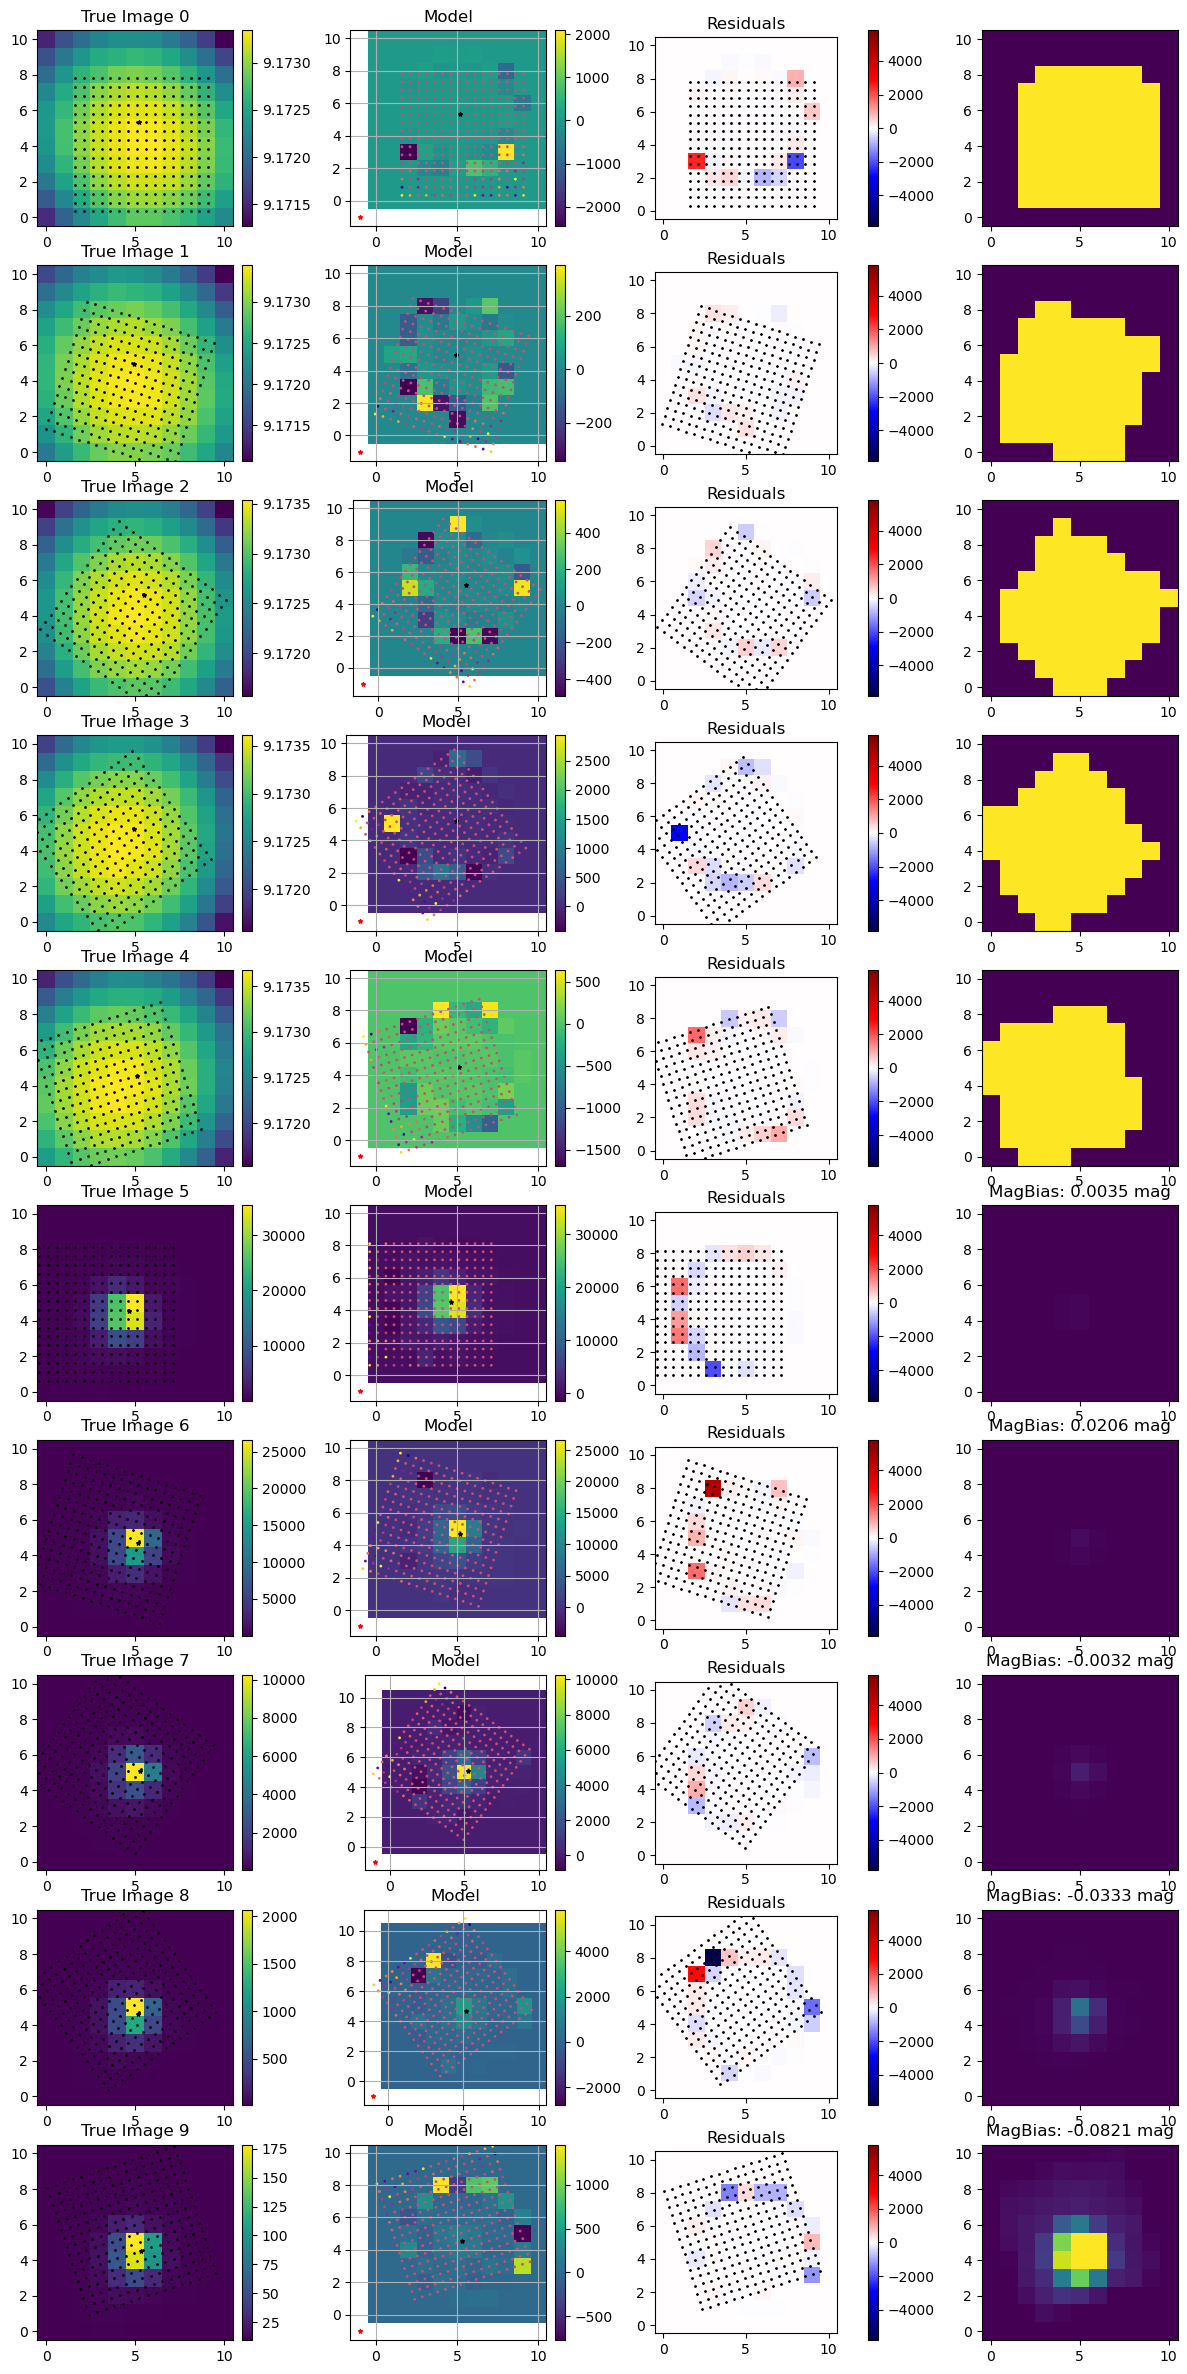

In [4]:
biases = []

fig = plt.figure(figsize = (15,3*testnum))



pred = X * psf_matrix




sumimages = np.sum(pred, axis = 1)
if make_initial_guess and testnum - detim != 0:
    pred0 = x0test.flatten() * psf_matrix
    sumimages0 = np.sum(pred0, axis = 1)
if detim > 0:
    magresiduals = -2.5*np.log10(X[-detim:])+2.5*np.log10(np.array(supernova))

galxes = []
stds = []
biases = []

for i, wcs in enumerate(cutout_wcs_list):

    extent = [-0.5, size-0.5, -0.5, size-0.5]
    if type(wcs) == galsim.fitswcs.AstropyWCS:
        #galx, galy = wcs.toImage(galra, galdec, units='deg')
        print('removing gal ra and galdec for now, something is broken')
        galx, galy = 0, 0
        xx, yy = cutout_wcs_list[i].toImage(ra_grid, dec_grid,units='deg')
    else:
        galx, galy = cutout_wcs_list[i].world_to_pixel(SkyCoord(ra = galra*u.degree, dec = galdec*u.degree))
        xx, yy = cutout_wcs_list[i].world_to_pixel(SkyCoord(ra = ra_grid*u.degree, dec = dec_grid*u.degree))
        

    xx -= 1
    yy -= 1


   
    snx, sny = wcs.toImage(snra, sndec, units = 'deg')
    
    plt.subplot(len(cutout_wcs_list), 4, 4*i+1)
    plt.scatter(xx, yy, color = 'k', s = 1)
    plt.title('True Image ' + str(i))
    plt.scatter(snx-1, sny-1, c = 'k', s = 8, marker = '*')
    print(galx,galy)
    plt.scatter(galx-1,galy-1, c = 'r', s = 8, marker = '*')
    plt.imshow(images[i*size**2:(i+1)*size**2].reshape(size,size), origin = 'lower', extent = extent)
    plt.colorbar(fraction=0.046, pad=0.04)
    trueimage = images[i*size**2:(i+1)*size**2].reshape(size,size)

    '''
    
    argsort = np.argsort(trueimage.flatten())
    brightest = argsort[-5:]
    print(brightest)
    print('Brightest pixels in image', trueimage.flatten()[brightest])
    for k in range(5):
        #label each point with its value

        xbright = brightest[k]%size
        ybright = brightest[k]//size
        xmod = (xbright - 5)
        ymod = (ybright - 5)

        plt.text(xbright + xmod,ybright + ymod, str(np.round(trueimage.flatten()[brightest][k],0)), fontsize = 8, color = 'C'+str(k))
        plt.scatter(brightest[k]%size, brightest[k]//size, color = 'C'+str(k), s = 10)
    '''

    ############################################

    plt.subplot(len(cutout_wcs_list), 4, 4*i+2)
    plt.title('Model')
    
    im1 = sumimages[i*size**2:(i+1)*size**2].reshape(size,size)
    if type(cutout_wcs_list[i]) == galsim.fitswcs.AstropyWCS:
        xx, yy = cutout_wcs_list[i].toImage(ra_grid, dec_grid,units='deg')
    else:
        xx, yy = cutout_wcs_list[i].world_to_pixel(SkyCoord(ra = ra_grid*u.degree, dec = dec_grid*u.degree))

    xx -= 1
    yy -= 1

    if weighting:
        print('multiplying by weights')
        
    vmin = np.min(images[i*size**2:(i+1)*size**2].reshape(size,size))
    vmax = np.max(images[i*size**2:(i+1)*size**2].reshape(size,size))

    if weighting:
        im1[np.where(wgt_matrix[i*size**2:(i+1)*size**2].reshape(size,size) == 0)] = 0
    #plt.imshow(im1, extent = extent, origin = 'lower', vmin = vmin, vmax = vmax)
    plt.imshow(im1, extent = extent, origin = 'lower')
    plt.colorbar(fraction=0.046, pad=0.04)
    

    if fit_background:
        plt.scatter(xx,yy, c = X[:np.size(ra_grid)], cmap = 'plasma', s = 1)
    elif not single_grid_point:
        if detim != 0:
            plt.scatter(xx,yy, c = X[:-testnum], cmap = 'plasma', s = 1)
        else:
            plt.scatter(xx,yy, c = X, cmap = 'plasma', s = 1)

    
    
    plt.scatter(galx-1,galy-1, c = 'r', s = 8, marker = '*')
    plt.scatter(snx-1, sny-1, c = 'k', s = 8, marker = '*')

    #plt.xlim(-1,size)
    #plt.ylim(-1,size)
    plt.grid(True, which = 'both')
    
    ############################################
    plt.subplot(len(cutout_wcs_list),4,4*i+3)
    plt.title('Residuals')
    plt.scatter(xx,yy,color = 'k', s = 1)
    res = images - sumimages
    if weighting:
        print('multiplying by weights')
        #res*=wgt_matrix
        
        
    current_res= res[i*size**2:(i+1)*size**2].reshape(size,size)
    if weighting:
        current_res[np.where(wgt_matrix[i*size**2:(i+1)*size**2].reshape(size,size) == 0)] = 0
        print('BIAS', np.mean(current_res[np.where(wgt_matrix[i*size**2:(i+1)*size**2].reshape(size,size) != 0)]))
        biases.append(np.mean(current_res[np.where(wgt_matrix[i*size**2:(i+1)*size**2].reshape(size,size) != 0)]))
        print('STD', np.std(current_res[np.where(wgt_matrix[i*size**2:(i+1)*size**2].reshape(size,size) != 0)]))

    galxes.append(galx)
    biases.append(np.mean(current_res))
    stds.append(np.std(current_res))
    if i == 0:
        norm = np.max(np.abs(res[np.where(wgt_matrix != 0)]))
    #norm = 1

    plt.imshow(current_res, extent = extent, origin = 'lower', cmap = 'seismic', vmin = -norm, vmax = norm)
    #plt.imshow(wgt_matrix[i*size**2:(i+1)*size**2].reshape(size,size), extent = extent, origin = 'lower')
    plt.colorbar(fraction=0.046, pad=0.14)
    #plt.scatter(galx,galy, c = 'r', s = 12, marker = '*', edgecolors='k')
    

    ############################################
    plt.subplot(len(cutout_wcs_list),4,4*i+4)
    #plt.hist(trueimage.flatten(), bins = np.linspace(-50,50,20), histtype = 'step', color = 'k', density = True)
    
    if i >= testnum - detim:
        plt.title('MagBias: ' + str(np.round(magresiduals[i - testnum + detim],4)) + ' mag')

    im1_guess = sumimages0[i*size**2:(i+1)*size**2].reshape(size,size)
    plt.imshow(im1_guess, extent = extent, origin = 'lower', vmin = vmin, vmax = vmax)
    
    #plt.hist(current_res[np.where(wgt_matrix[i*size**2:(i+1)*size**2].reshape(size,size) != 0)], bins = np.linspace(-norm/2,norm/2,30), histtype = 'step', color = 'k', density = True)
    #plt.axvline(np.mean(trueimage.flatten()[np.where(trueimage.flatten()< 50)]), color = 'r')
    '''
    justbgX = np.copy(X)
    justbgX[-testnum:] = 0

    justbgpred = justbgX * psf_matrix
    justbgsumimages = np.sum(justbgpred, axis = 1)
    justbgim = justbgsumimages[i*size**2:(i+1)*size**2].reshape(size,size)
    

    #subtract off the real sn
    #if i >= testnum - detim:
        #print('subtracting sn')
        #justbgim -= sn_matrix[i*size**2:(i+1)*size**2, i].reshape(size,size)*supernova[i - testnum + detim]
    


    
    #get the 5 brightest pixels in the image
    justbgres = trueimage - justbgim
    im1 = sumimages[i*size**2:(i+1)*size**2].reshape(size,size)


    plt.plot(trueimage[5], label = 'Image')
    plt.plot(im1[5], label = 'Model')
    plt.plot(justbgim[5], label = 'Background Only')
    plt.plot(justbgres[5], label = 'Image Background Subtracted')
    
    if i >= testnum - detim:
        snim = sn_matrix[i*size**2:(i+1)*size**2, i].reshape(size,size)*supernova[i - testnum + detim]
        print('multiplying by ', supernova[i - testnum + detim])
    else:
        snim = np.zeros_like(justbgres)


    plt.plot(snim[5], label = 'Perfect Supernova')
    plt.axvline(snx-1+1, ls = '--', color = 'k')
    plt.axvline(snx-1-1, ls = '--', color = 'k')
    if i >= testnum - 1 or i == 0:
        plt.legend()
    
    #plt.imshow(justbgres, extent = extent, origin = 'lower', vmin = -200, vmax = 200)
    #plt.colorbar(fraction=0.046, pad=0.04)
    '''
 

plt.subplots_adjust(wspace = 0.4)

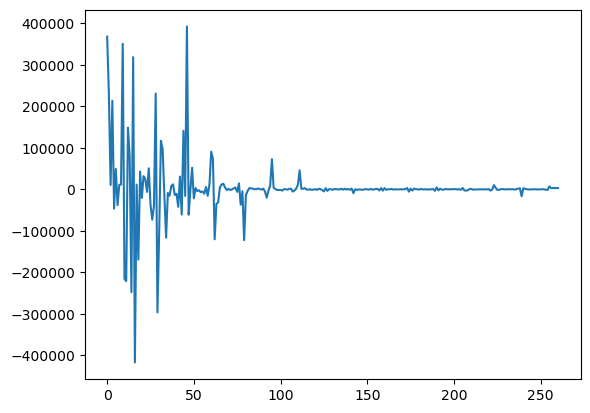

In [6]:
plt.plot(X[:-detim])

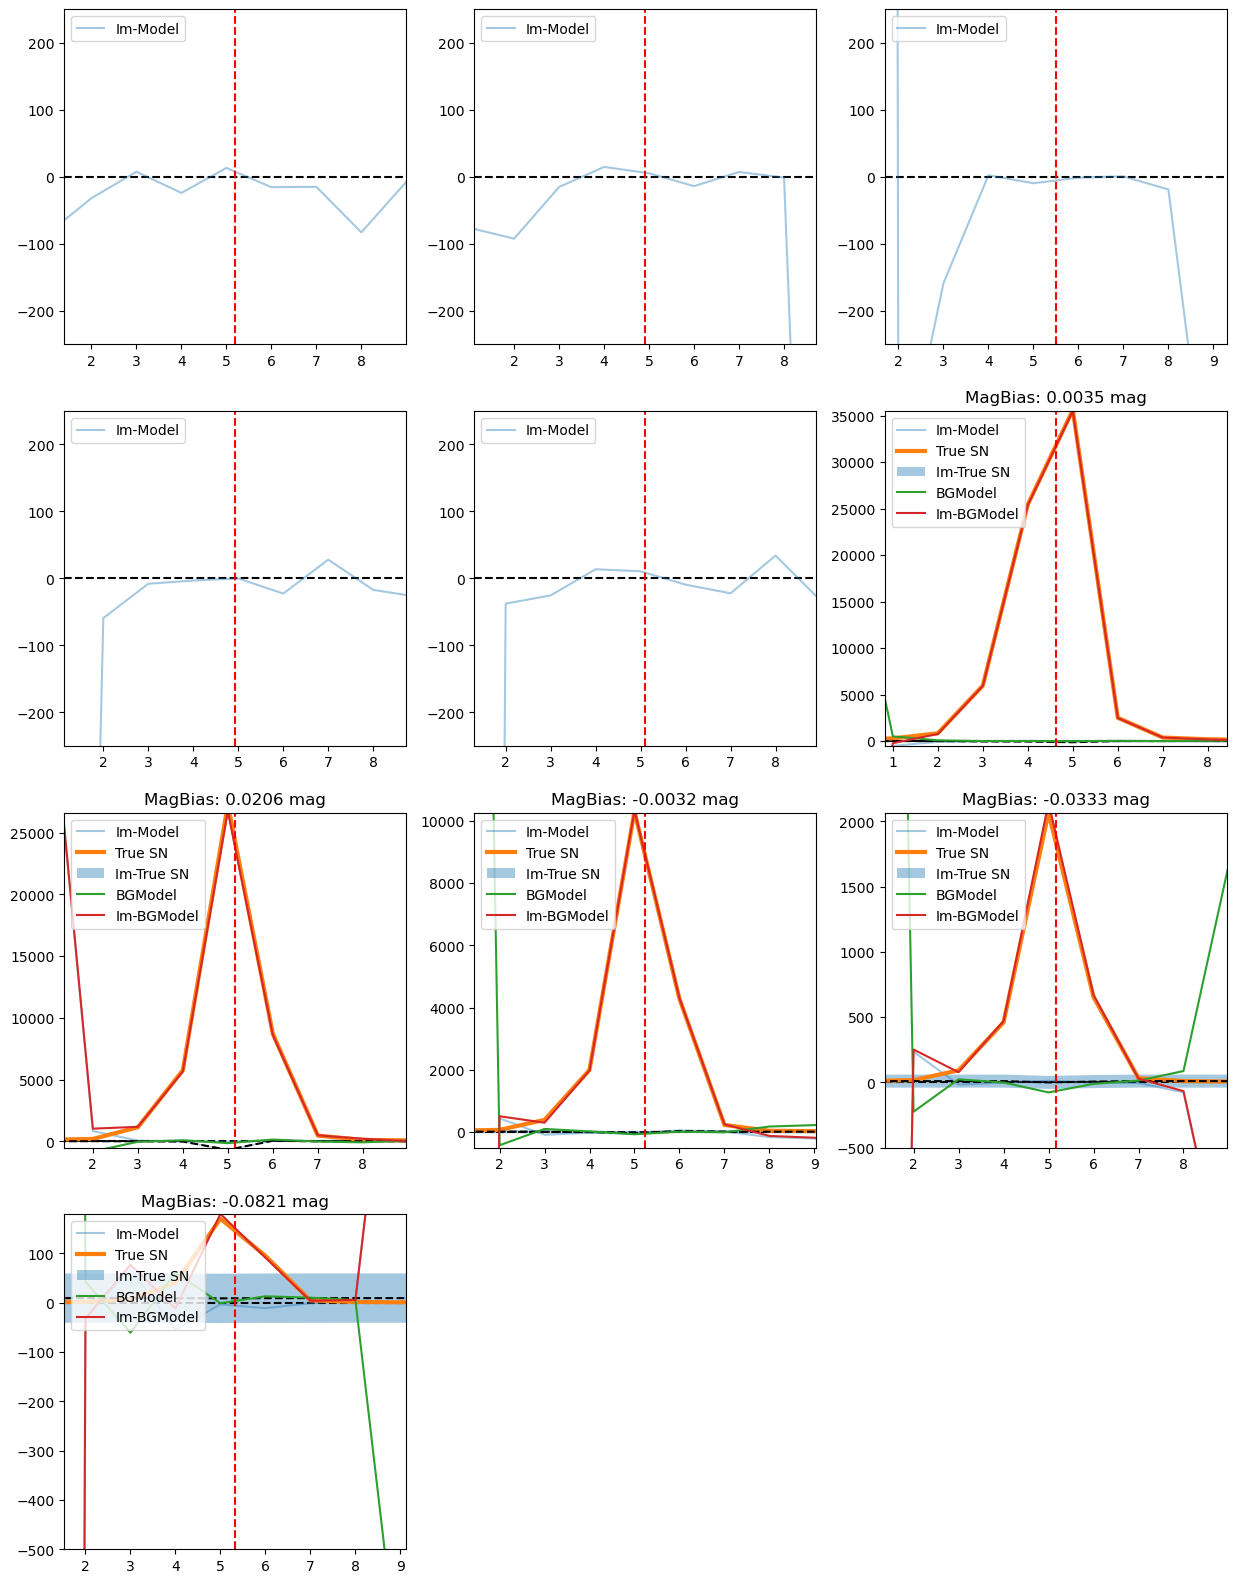

In [7]:
biases = []
fig = plt.figure(figsize = (15,2*testnum))


#realSNX = np.copy(X)
#
# NX[-detim:] = supernova
#X = np.zeros_like(X)
#X[50] = 500000
pred = X * psf_matrix
#print(pred[50])
#print('setting X to 0 as A TEST AAAAAAAAAAAAAAAAAACJDABHSLJFNSJDF')

centralpixel_model = []
centralpixel_image = []


sumimages = np.sum(pred, axis = 1)
if make_initial_guess and testnum - detim != 0:
    pred0 = x0test.flatten() * psf_matrix
    sumimages0 = np.sum(pred0, axis = 1)

if detim > 0:
    magresiduals = -2.5*np.log10(X[-detim:])+2.5*np.log10(np.array(supernova))

galxes = []
stds = []
biases = []

for i, wcs in enumerate(cutout_wcs_list):

    extent = [-0.5, size-0.5, -0.5, size-0.5]
    trueimage = images[i*size**2:(i+1)*size**2].reshape(size,size)
    snx, sny = wcs.toImage(snra, sndec, units = 'deg')

    plt.subplot(len(cutout_wcs_list)//3 + 1,3,i+1)
    if i >= testnum - detim:
        plt.title('MagBias: ' + str(np.round(magresiduals[i - testnum + detim],4)) + ' mag')


    justbgX = np.copy(X)
    justbgX[-testnum:] = 0

    justbgpred = justbgX * psf_matrix
    justbgsumimages = np.sum(justbgpred, axis = 1)
    justbgim = justbgsumimages[i*size**2:(i+1)*size**2].reshape(size,size)
    

    #subtract off the real sn
    #if i >= testnum - detim:
        #print('subtracting sn')
        #justbgim -= sn_matrix[i*size**2:(i+1)*size**2, i].reshape(size,size)*supernova[i - testnum + detim]
    


    
    justbgres = trueimage - justbgim
    im1 = sumimages[i*size**2:(i+1)*size**2].reshape(size,size)


    #plt.plot(trueimage[5], label = 'Image')
    centralpixel_image.append(np.sum(trueimage[5][3:7]))
    plt.axhline(0, ls = '--', color = 'k')
    #plt.plot(im1[5], label = 'Model', lw = 3)
    plt.plot(trueimage[5] - im1[5], label = 'Im-Model', alpha = 0.4)
    plt.ylim(-250,250)
    centralpixel_model.append(np.sum(justbgim[5][3:7]))

    
    
    if i >= testnum - detim:
        snim = sn_matrix[i*size**2:(i+1)*size**2, i].reshape(size,size)*supernova[i - testnum + detim]
        plt.plot(snim[5], label = 'True SN', lw = 3)
        plt.fill_between(np.arange(0,11,1), trueimage[5] - snim[5] + 50, trueimage[5] - snim[5] - 50, label = 'Im-True SN', alpha = 0.4)
        plt.plot(np.arange(0,11,1), trueimage[5] - snim[5] , color = 'k', ls = '--')
        plt.plot(justbgim[5], label = 'BGModel')
        plt.plot(justbgres[5], label = 'Im-BGModel')
        
        #plt.plot(justbgres[5] - snim[5], label = 'SN Residuals', ls = '--')
        plt.ylim(-500,np.max(trueimage[5]))
        snim = sn_matrix[i*size**2:(i+1)*size**2, i].reshape(size,size)*X[-detim:][i - testnum + detim]

    else:
        snim = np.zeros_like(justbgres)


    
    plt.axvline(snx-1+4, ls = '--', color = 'k')
    plt.axvline(snx-1-4, ls = '--', color = 'k')
    plt.axvline(snx-1, ls = '--', color = 'r')

    plt.xlim(snx-1-3.8, snx-1+3.8)


    plt.legend(loc = 'upper left')
    




In [8]:
assert False

AssertionError: 

In [ ]:
#Plot the lightcurve we found.



if use_real_images:
    supernova = np.array(exposures['realized flux'][np.where(exposures['DETECTED'])])
else:
    supernova = np.array(supernova)


plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
if use_real_images:
    plt.title('Supernova ID: ' + str(ID) + '\n' + 'Grid Points: ' + str(np.size(ra_grid)) + 'Adaptive = ' + str(adaptive_grid))
    dates = exposures['date'][np.where(exposures['DETECTED'])]
else:
    dates = np.arange(detim)
    plt.title('Grid Points: ' + str(np.size(ra_grid)) + 'Adaptive = ' + str(adaptive_grid))


plt.scatter(dates, 14-2.5*np.log10(supernova), color = 'k', label = 'Truth')
plt.scatter(dates, 14-2.5*np.log10(X[-detim:]), color = 'purple', label = 'Model')

plt.ylim(14 - 2.5*np.log10(np.min(supernova)) + 0.2, 14 - 2.5*np.log10(np.max(supernova)) - 0.2)
plt.ylabel('Magnitude (Uncalibrated)')


bias = np.mean(-2.5*np.log10(X[-detim:])+2.5*np.log10(np.array(supernova)))
bias *= 1000
bias = np.round(bias, 2)
scatter = np.std(-2.5*np.log10(X[-detim:])+2.5*np.log10(np.array(supernova)))
scatter *= 1000
scatter = np.round(scatter, 2)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
textstr = 'Overall Bias: ' + str(bias) + ' mmag \n' + \
    'Overall Scatter: ' + str(scatter) + ' mmag'
plt.text(np.mean(dates), 14 - 2.5*np.log10(np.mean(supernova)), textstr,  fontsize=14,
        verticalalignment='top', bbox=props)
print(np.mean(dates), 14 - 2.5*np.log10(np.mean(supernova)) + .8)
print(textstr)
plt.legend()

print(supernova)
print(X[-detim:])

plt.subplot(2,1,2)

flux_mode = False
if flux_mode:
    plt.scatter(dates, X[-detim:] - supernova, color = 'k')
    for i,dr in enumerate(zip(dates, X[-detim:] - supernova)):
        d,r = dr
        plt.text(d+1,r,i+testnum-detim, fontsize = 8)
else:
    plt.scatter(dates, -2.5*np.log10(X[-detim:])+2.5*np.log10(supernova), color = 'k')
    plt.plot([np.min(dates), np.max(dates)], [0,0], ls = '--', color = 'k')
    plt.ylabel('Mag Residuals (Model - Truth)')
    plt.xlabel('MJD')
    plt.ylim(-0.1, 0.1)
    for i,dr in enumerate(zip(dates, -2.5*np.log10(X[-detim:])+2.5*np.log10(supernova))):
        d,r = dr
        plt.text(d+1,r,i+testnum-detim, fontsize = 8)

plt.axhline(0.001, color = 'r', ls = '--')
plt.axhline(-0.001, color = 'r', ls = '--', label = 'Millimag photometry')

plt.axhline(0.02, color = 'b', ls = '--')
plt.axhline(-0.02, color = 'b', ls = '--', label = '20 mmag photometry, \n Revised goal until we can sort out PSF')



plt.legend()


In [ ]:
print(len(sn_storage))

k = 0

plt.subplot(1,3,1)
plt.imshow(sn_storage[k])
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(fit_sn_storage[k].reshape(11,11)*supernova[k])
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(sn_storage[k] - fit_sn_storage[k].reshape(11,11)*supernova[k])
plt.colorbar()

In [ ]:
#Cycle through the files in this directory and plot the residuals

files = os.listdir()
os.chdir('/hpc/home/cfm37/RomanASP')

mags = []
residuals = []

#cd into results
os.chdir('./results')
files = os.listdir()
print(files)
allresiduals = []
for f in files:
    if 'detections' in f:
        print('----')
        

        residuals = pd.read_csv(f)
        print(residuals['confusion_metric'])


        mag_residual = -2.5*np.log10(residuals['measured_flux']) +2.5 * np.log10(residuals['realized flux'])
        ID = f.split('_')[0]
        plt.scatter(14 - 2.5*np.log10(residuals['realized flux']), mag_residual, marker = 'o', label = ID, c = np.log10(residuals['confusion_metric']), vmin = -1, vmax = 3)
        #plt.text(14 - 2.5*np.log10(residuals['realized flux'][0]), np.max(np.abs(mag_residual)), str(residuals['id'][0]))
        print(ID)
        allresiduals.extend(mag_residual)





#plt.legend()
plt.axhline(0, color = 'k', ls = '--')
plt.axhline(0.02, color = 'k', ls = '--')
plt.axhline(-0.02, color = 'k', ls = '--')
plt.xlim(4,6)
plt.ylim(-0.2,0.2)
plt.colorbar()
print(np.nanmean(allresiduals))
print(np.nanstd(allresiduals))


In [ ]:
plt.hist(allresiduals, bins = np.linspace(-0.2,0.2,100), histtype = 'step', color = 'k')
plt.axvline(np.nanmean(allresiduals), color = 'r')
plt.axvline(0, color = 'k')
plt.axvline(20/1000, color = 'k')
plt.axvline(-20/1000, color = 'k')

In [ ]:
#Cycle through the files in this directory and plot the residuals

files = os.listdir()
os.chdir('/hpc/home/cfm37/RomanASP')

mags = []
residuals = []

#cd into results
os.chdir('./results')
files = os.listdir()
print(files)
allresiduals = []
for f in files:
    if 'detections' in f:
        print('----')
        

        residuals = pd.read_csv(f)
        print(residuals['confusion_metric'])


        mag_residual = -2.5*np.log10(residuals['measured_flux']) +2.5 * np.log10(residuals['realized flux'])
        flux_residual = residuals['measured_flux'] - residuals['realized flux']
        ID = f.split('_')[0]
        std = np.nanstd(mag_residual)
        std = np.nanstd(flux_residual)
        bias = np.nanmean(mag_residual) 
        plt.scatter(np.log10(residuals['confusion_metric'][0]), std, marker = 'o', label = ID)
        #plt.text(14 - 2.5*np.log10(residuals['realized flux'][0]), np.max(np.abs(mag_residual)), str(residuals['id'][0]))
        print(ID)
        allresiduals.extend(mag_residual)





In [ ]:
config_file = './temp_tds.yaml'
pointing = 662
SCA = 11
util_ref = roman_utils(config_file=config_file, visit = pointing, sca=SCA)
stampsize = 11
x =2000
y = 2000
x_center = 5
y_center = 5
a  = getPSF_Image(util_ref, stampsize, x=x, y=y,  x_center = x_center, y_center=y_center,include_photonOps=True).array
b = getPSF_Image(util_ref, stampsize, x=x, y=y,  x_center = x_center, y_center=y_center,include_photonOps=True).array

plt.figure(figsize=(10,5))
plt.imshow((a-b).reshape(11,11)/a.reshape(11,11), vmin = -0.05, vmax = 0.05, cmap = 'seismic')
plt.colorbar()
plt.contour(a.reshape(11,11))



In [ ]:
plt.hist((images - sumimages)[np.where(wgt_matrix != 0)], bins = 100, alpha = 0.5, label = 'Residuals', density= True)
#overplot a gaussian
mean = np.mean((images - sumimages)[np.where(wgt_matrix != 0)])
std = 50

x = np.linspace(-3*std,3*std,100)
plt.plot(x, 1/(std*np.sqrt(2*np.pi))*np.exp(-0.5*(x-mean)**2/std**2), label = 'Gaussian Fit')

In [ ]:
sn_path = '/cwork/mat90/RomanDESC_sims_2024/roman_rubin_cats_v1.1.2_faint/'
plt.figure(figsize = (5,25))
band = 'F184'
pointing, SCA = 13021, 15
cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{pointing}/Roman_TDS_index_{band}_{pointing}_{SCA}.txt',\
                                sep="\s+", skiprows = 1,
                                names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])
cat_star = cat.loc[cat['obj_type'] == 'star']
IDs = []
ras = []
decs = []
for i in np.linspace(4,7,1):
    #print(i)
    #print(np.max(cat_star['mag']), np.min(cat_star['mag']))
    cat_close = cat_star.loc[np.isclose(cat_star['mag'], i, atol = 0.1)]
    IDs.append(cat_close.object_id.values[0])
    ras.append(cat_close.ra.values[0])
    decs.append(cat_close.dec.values[0])


print(IDs)

size = 25  
nbg = -1
plt.figure(figsize = (30,30))
for i, ID in enumerate(IDs):
    ra = ras[i]
    dec = decs[i]
    start = 0
    end = 10**999
    p = pointing
    s = SCA
    peak = 0

    server_url = 'https://roman-desc-simdex.lbl.gov'
    req = requests.Session()
    result = req.post( f'{server_url}/findromanimages/containing=({ra},{dec})' )
    if result.status_code != 200:
        raise RuntimeError( f"Got status code {result.status_code}\n{result.text}" )

    res = pd.DataFrame(result.json())[['filter','pointing','sca', 'mjd']]
    res.rename(columns = {'mjd':'date', 'pointing': 'Pointing', 'sca': 'SCA'}, inplace = True)
    print(res.shape[0], 'Potential Candidates')
    res = res.loc[res['filter'] == band]

    realized_flux = []
    measured_flux = []
    zpts = []
    k = 0
    for index, row in res.iterrows():
        print('-----------------------')

        p = row['Pointing']
        s = row['SCA']
        image = fits.open(roman_path + f'/RomanTDS/images/truth/{band}/{p}/Roman_TDS_truth_{band}_{p}_{s}.fits.gz')
        scawcs = WCS(image[0].header)
        x,y = scawcs.world_to_pixel(SkyCoord(ra = ra*u.degree, dec = dec*u.degree))
        if x < 25 or x > 2*2048 - 25 or y < 25 or y > 2*2048 - 25:
            print('Out of bounds')
            continue

        cutout = Cutout2D(image[0].data, SkyCoord(ra = ra*u.degree, dec = dec*u.degree), size, wcs = scawcs)
        cutoutwcs = galsim.AstropyWCS(wcs = cutout.wcs)
        x_center, y_center = cutoutwcs.toImage(ra, dec, units = 'deg')
        #make a reference point
        x_ref, y_ref = cutoutwcs.toImage(ra+1e-5, dec+1e-5, units = 'deg')
        psf = construct_psf_source(x, y, pointing, SCA, stampsize=25,  x_center = x_center, y_center = y_center)
        #fit the psf to the image
        im = cutout.data
        plt.subplot(4,2,2*k+1)
        plt.imshow(im.reshape(25,25), origin = 'lower')
        plt.grid('True')
        plt.colorbar()
        plt.subplot(4,2,2*k + 2)
        k+=1
        plt.grid('True')
        im = im.flatten()
        #im -= image[1].header['SKY_MEAN']
        psf = psf.flatten()
        psf = psf.reshape(-1,1)
        lsqr = sp.linalg.lsqr(psf, im, atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)
        plt.imshow(im.reshape(25,25) - psf.reshape(25,25) * lsqr[0][0], origin = 'lower', cmap = 'seismic', vmax = 100, vmin = -100)
        

        plt.colorbar()
        plt.scatter(x_ref, y_ref, color = 'k', marker = '*')
        
        #plt.contour(psf.reshape(25,25) * lsqr[0][0], levels = 10)
        cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{p}/Roman_TDS_index_{band}_{p}_{s}.txt',\
                                sep="\s+", skiprows = 1,
                                names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])

        cat_star = cat.loc[cat['obj_type'] == 'star']
        logflux = -2.5*np.log10(cat_star['flux'])
        exptime = image[0].header['EXPTIME']
        area_eff = roman.collecting_area
        galsim_zp = roman.getBandpasses()[band].zeropoint
        truthmag = -2.5*np.log10(cat['flux']) + 2.5*np.log10(exptime*area_eff) + galsim_zp
        mag = cat_star['mag']


        zpt = np.nanmedian(truthmag)
        print(zpt, 'zpt')
        zpts.append(zpt)

        
        cat = cat.loc[cat['object_id'] == ID]
        print('realized flux', cat['realized_flux'])
        print('measured flux', lsqr[0])
        

        realized_flux.append(cat['realized_flux'].values[0])
        measured_flux.append(lsqr[0][0])
        plt.title('Mag Error' + str(-2.5 * np.log10(lsqr[0][0])- -2.5*np.log10(cat['realized_flux'].values[0])) )

        if len(realized_flux) == 4:
            break
    '''
    std = np.std(-2.5*np.log10(np.array(realized_flux)) - (-2.5*np.log10(np.array(measured_flux))))
    mean = np.mean(-2.5*np.log10(np.array(realized_flux)) - (-2.5*np.log10(np.array(measured_flux))))
    print('STD:', std)
    print('mean:', mean)
    print('ZPT:', zpts)
    print('Measured:', measured_flux)
    print('Realized:', realized_flux)
    plt.plot(-2.5*np.log10(np.array(realized_flux)) + np.array(zpts), color = 'C' + str(i), ls = '--')
    plt.plot(-2.5*np.log10(np.array(measured_flux)) + np.array(zpts), color = 'C' + str(i))
    plt.text(4.5, np.mean(-2.5*np.log10(np.array(measured_flux)) + np.array(zpts)), 'Mean: ' + str(np.round(mean,2)) + ' STD: ' + str(np.round(std,2)), color = 'C' + str(i)) 
    '''
        
        


plt.legend()
    

In [ ]:
sn_path = '/cwork/mat90/RomanDESC_sims_2024/roman_rubin_cats_v1.1.2_faint/'
plt.figure(figsize = (7,7))
band = 'J129'

realized_flux = []
measured_flux = []

for SCA in range(1,19):
    if len(realized_flux) == 200:
            break
    print('Switching to SCA ', SCA)

    pointing = 17139
    size = 25
    cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{pointing}/Roman_TDS_index_{band}_{pointing}_{SCA}.txt',\
                                    sep="\s+", skiprows = 1,
                                    names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])
    cat_star = cat.loc[cat['obj_type'] == 'star']
    cat_star = cat_star.loc[cat_star['mag'] < 7]
    cat_star = cat_star.loc[cat_star['mag'] > 0]
    print(np.size(cat_star['flux']))

    image = fits.open(roman_path + f'/RomanTDS/images/truth/{band}/{pointing}/Roman_TDS_truth_{band}_{pointing}_{SCA}.fits.gz')
    scawcs = WCS(image[0].header)



    for i, row in cat_star.iterrows():
        print(i, row['mag'])
        ra = row['ra']
        dec = row['dec']
        x,y = scawcs.world_to_pixel(SkyCoord(ra = ra*u.degree, dec = dec*u.degree))
        if x < 25 or x > 2*2048 - 25 or y < 25 or y > 2*2048 - 25:
            print('Out of bounds')
            continue
        cutout = Cutout2D(image[0].data, SkyCoord(ra = ra*u.degree, dec = dec*u.degree), size, wcs = scawcs)
        cutoutwcs = galsim.AstropyWCS(wcs = cutout.wcs)
        x_center, y_center = cutoutwcs.toImage(ra, dec, units = 'deg')
        psf = construct_psf_source(x, y, pointing, SCA, stampsize=25,  x_center = x_center, y_center = y_center)
        #fit the psf to the image
        im = cutout.data
        im = im.flatten()
        psf = psf.flatten()
        psf = psf.reshape(-1,1)
        lsqr = sp.linalg.lsqr(psf, im, atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)
        realized_flux.append(row['realized_flux'])
        measured_flux.append(lsqr[0][0])
        if len(realized_flux) == 200:
            break




    

In [ ]:
realized_mag = -2.5*np.log10(np.array(realized_flux))
measured_mag = -2.5*np.log10(np.array(measured_flux))
cat = pd.read_csv(roman_path+f'/RomanTDS/truth/{band}/{pointing}/Roman_TDS_index_{band}_{pointing}_{SCA}.txt',\
                                sep="\s+", skiprows = 1,
                                names = ['object_id', 'ra', 'dec', 'x', 'y', 'realized_flux', 'flux', 'mag', 'obj_type'])
cat_star = cat.loc[cat['obj_type'] == 'star']

exptime = image[0].header['EXPTIME']
area_eff = roman.collecting_area
galsim_zp = roman.getBandpasses()[band].zeropoint
truthmag = -2.5*np.log10(cat['flux']) + 2.5*np.log10(exptime*area_eff) + galsim_zp
mag = cat_star['mag']
logflux = -2.5*np.log10(cat_star['flux'])
zpt = np.nanmedian(truthmag - logflux)
#truthmag = truthmag - zpt
# - np.median(truthmag)
#zpt = np.nanmedian(truthmag)
print(zpt)
plt.scatter(realized_mag + zpt, realized_mag - measured_mag)
plt.xlabel('True Magnitude')
plt.ylabel('True - Measured Magnitude')
plt.axvline(20, color = 'k', ls = '--')
plt.axvline(21, color = 'k', ls = '--')
plt.axhline(0, color = 'k', ls = '--')
residuals = realized_mag - measured_mag

residuals = residuals[np.where((realized_mag + zpt < 21) & (realized_mag + zpt > 20))]
print(residuals)
print(np.nanstd(residuals))
plt.text(20.5, -0.05, 'sigma = ' + str(np.round(np.nanstd(residuals),4)))
plt.title(band)
plt.ylim(-0.1,0.1)

In [ ]:
plt.scatter(cat_star['mag'], -2.5*np.log10(cat_star['flux']) + 2.5*np.log10(exptime*area_eff) + galsim_zp)

In [ ]:
df = open_parq(10430, path = sn_path)
reals = df.loc[(df.peak_mjd < 62800.0)]
reals = reals.loc[(df.peak_mjd > 62400.0)]
reals = reals.loc[reals.host_mag_F < 999]
#reals = reals.loc[reals.ra > 6.487]
reals = reals.loc[reals.ra > 7]
#reals = reals.loc[reals.ra < 12.51]
reals = reals.loc[reals.ra < 8]
#reals = reals.loc[reals.dec > -46.877]
reals = reals.loc[reals.dec > -45]
#reals = reals.loc[reals.dec < -41.124]
reals = reals.loc[reals.dec < -44]
df = reals
df = df.sort_values('peak_mag_F')
print(list(df.id[4:28]))

In [ ]:
biases = []
stds = []




roman_bandpasses = galsim.roman.getBandpasses()



galwcs2 = None
ra_max = None
###################### BEGIN TEST PARAMETERS #######################
band = 'F184'
npoints = 7
size = 11
testnum = 30 #Total number of images
detim = 15  #Number of images with a supernova

#PSF for when not using the Roman PSF
lam = 1293  # nm
lam_over_diam = 0.11300864172775239   #This is the roman value
airy = galsim.ChromaticOpticalPSF(lam, diam = 2.36, aberrations=galsim.roman.getPSF(1,band, pupil_bin = 1).aberrations)

use_real_images = True
use_roman = True

# These are only for my simulated images # 
check_perfection = False #Don't bother with these five
make_exact = False
avoid_non_linearity = False
deltafcn_profile = False 
single_grid_point = False 


do_xshift = True    #whether to shift the images in the x direction (they will still be centered on the same point, this is just to emulate\
        #Roman taking a series of images at different locations.)
do_rotation = True #whether to rotate the images
noise = 50 #Standard Deviation of noise to add to a simulated image. 
background_level = 300  #mean of the noise to add to the image
if detim == 0:
    supernova = 0
else:
    d = np.linspace(5,20,detim)
    mags = -5 * np.exp(-d/10) + 6
    fluxes = 10**(mags)
    supernova = list(fluxes)   #This is my faux lightcurve, you can edit this if you want to test with a different lightcurve.
#########################################


make_initial_guess = False  #Make an initial guess for the grid point values by averaging over pixels
adaptive_grid = True       #Use my new adaptive grid method rather than a static evenly spaced grid. Bizarrely, this seems to be worse
                            #when just fitting background, but gives better results when fitting for the supernova flux.


fit_background = False     #If true, each image will have a new parameter introduced with it that fits for the background. If False
                            #the background will be subtracted from the images before fitting based on the background level over the whole image.
                            #So far, I've found keeping this to be False is better.

weighting = True #Apply a weighting to the fit. Currently, this is a tophat of radius 4 pix around the SN location. 
                #I've been experimenting with including a Gaussian on top of this.



if single_grid_point:
    assert make_exact
if avoid_non_linearity:
    assert deltafcn_profile
assert detim <= testnum
if type(supernova) == 'list':
    assert len(supernova) == detim

method = 'lsqr'  #Fitting method used at the end of the algorithm. LSQR is by far the best I need to remove this option. 

galsim.roman.roman_psfs._make_aperture.clear() #clear cache

sed = galsim.SED(galsim.LookupTable([100, 2600], [1,1], interpolant='linear'),
                                wave_type='nm', flux_type='fphotons')

###################### END TEST PARAMETERS #######################

#10430
df = open_parq(10430, path = sn_path)
reals = df.loc[(df.peak_mjd < 62800.0)]
reals = reals.loc[(df.peak_mjd > 62400.0)]
reals = reals.loc[reals.host_mag_F < 999]
#reals = reals.loc[reals.ra > 6.487]
reals = reals.loc[reals.ra > 7]
#reals = reals.loc[reals.ra < 12.51]
reals = reals.loc[reals.ra < 8]
#reals = reals.loc[reals.dec > -46.877]
reals = reals.loc[reals.dec > -45]
#reals = reals.loc[reals.dec < -41.124]
reals = reals.loc[reals.dec < -44]
df = reals
df = df.sort_values('peak_mag_F')
for ID in df.id:
    print('starting SN ', ID)

    #Check if the file already exists
    if os.path.exists(f'./residuals_minortweaks_{str(ID)}.csv'):
        print('already completed' + str(ID))
        continue
    

    ################### Finding and Preparing Images Section #########
    psf_matrix = []
    imagelist = []
    wgt_matrix = []
    sn_matrix = []
    cutout_wcs_list = []
    im_wcs_list = []
    gridmade = False

    #This is a catch for when I'm doing my own simulated WCS's
    image = None
    util_ref = None

    #try
    if use_real_images:

        #Find SN Info, find exposures containig it, and load those as images. 
        pqfile = find_parq(ID, sn_path)
        ra, dec, p, s, start, end, peak, galra, galdec = \
            SNID_to_loc(ID, pqfile, date = True, band = band, snpath = sn_path, roman_path = roman_path, host = True)
        snra = ra
        sndec = dec
        start = start[0]
        end = end[0]
        exposures = findAllExposures(ID, ra,dec, peak,start,end, roman_path=roman_path, maxbg = testnum - detim, \
            maxdet = detim, return_list = True, band = band)
        if len(exposures) != testnum:
            print('Not enough exposures')
            continue

        images, cutout_wcs_list, im_wcs_list, err = constructImages(exposures, ra, dec, size = size, \
            background = fit_background, roman_path = roman_path)
        print(images)
        imlist = [images[i*size**2:(i+1)*size**2].reshape(size,size) for i in range(testnum)]

    else:
        #Simulate the images of the SN and galaxy.
        ra, dec = 7.541534306163982, -44.219205940734625
        snra = ra
        sndec = dec
        galra = ra + 1.5e-5
        galdec = dec + 1.5e-5
        print(snra,sndec,galra,galdec, 'SN AND GAL COORDINATES')

        images, im_wcs_list, cutout_wcs_list = simulateImages(testnum,detim,ra,dec,do_xshift,\
            do_rotation,supernova,noise = noise,use_roman=use_roman, size = size)
        imlist = [images[i*size**2:(i+1)*size**2].reshape(size,size) for i in range(testnum)]




    #If not using the adaptive grid, make a grid of points to fit over.
    if not adaptive_grid:
        if single_grid_point:
            ra_grid, dec_grid = [ra], [dec]
        else:
            ra_grid, dec_grid = local_grid(ra,dec, cutout_wcs_list[0], npoints, size = size, spacing = 0.75, spline_grid = False)
            #print('Using gradient grid!!!!!')
            #ra_grid, dec_grid = gradientGrid(images[0*size**2:(0+1)*size**2].reshape(size,size), cutout_wcs_list[0], ra_grid, dec_grid)
        if make_exact:
            if single_grid_point:
                galra = ra_grid[0]
                galdec = dec_grid[0]
            else:
                galra = ra_grid[106]
                galdec = dec_grid[106]

            
        ra_grid = np.array(ra_grid)
        dec_grid = np.array(dec_grid)
        gridmade = True

    #Apply the weighting mask to the images.
    if weighting:
        for i in range(testnum):
            xx, yy = np.meshgrid(np.arange(0,size,1), np.arange(0,size,1))
            xx = xx.flatten()
            yy = yy.flatten()
            rara, decdec = cutout_wcs_list[i].toWorld(xx, yy, units = 'deg')
            dist = np.sqrt((rara - snra)**2 + (decdec - sndec)**2)

            if use_real_images:
                error = err[i*size**2:(i+1)*size**2]

            snx, sny = cutout_wcs_list[i].toImage(snra, sndec, units = 'deg')
            dist = np.sqrt((xx - snx + 1)**2 + (yy - sny + 1)**2)
            #wgt = np.zeros(size**2)
            wgt = np.ones(size**2)
            

            wgt = 5*np.exp(-dist**2/2.5)
            print('using a gaussian weighting of 2.5')
            wgt[np.where(dist > 4)] = 0

            if use_real_images:
                wgt /= error
            wgt = wgt / np.sum(wgt)
            wgt_matrix.append(wgt)

    #If instead making an adaptive grid, use the weighted images to inform where grid points
    #should be placed.
    if adaptive_grid:
        a = images[:size**2].reshape(size,size)
        if weighting:
            wgt = wgt_matrix[0]
        else:
            wgt = np.ones_like(a)
            
        ra_grid, dec_grid = local_grid(ra,dec, cutout_wcs_list[0], \
                npoints, size = size,  spacing = 0.75, image = a, spline_grid = False)
        print('removed wgt when making adaptive grid')
        #*wgt.reshape(size,size)
        gridmade = True

    #ra_grid = np.array([])
    #dec_grid = np.array([])
    #print('manually setting ra and dec grid')

    #Using the images, hazard an initial guess.
    if make_initial_guess and testnum - detim != 0:
        if supernova != 0:
            x0test = generateGuess(imlist[:-detim], cutout_wcs_list, ra_grid, dec_grid)
            x0test = np.concatenate([x0test, np.full(testnum, 3000)], axis = 0)
            print('setting initial guess to 3000')
        else:
            x0test = generateGuess(imlist, cutout_wcs_list, ra_grid, dec_grid)

    else:
        x0test = None

    ############################################### Fitting Section ###############################################



    #Build the backgrounds loop
    for i in range(testnum):
        spinner = ['|', '/', '-', '\\']
        print('Constructing Model ' + str(i) + '   ' + spinner[i%4], end = '\r')
        if use_roman:
            sim_psf = galsim.roman.getPSF(1,band, pupil_bin=8, wcs = cutout_wcs_list[i])
        else:
            sim_psf = airy

        x,y = im_wcs_list[i].toImage(ra,dec, units = 'deg')

        #Build the model for the background using the correct psf and the grid we made in the previous section. 
        if use_real_images:
            util_ref = roman_utils(config_file='./temp_tds.yaml', visit = exposures['Pointing'][i], sca = exposures['SCA'][i])
        else:
            util_ref = roman_utils(config_file='./temp_tds.yaml', visit = 662, sca = 11)
        array = construct_psf_background(ra_grid, dec_grid, cutout_wcs_list[i],\
            x, y, size, roman_bandpasses[band], color=0.61, \
                psf = sim_psf, pixel = pixel, include_photonOps = False, util_ref = util_ref)

        
        if single_grid_point:
            pointx, pointy = cutout_wcs_list[i].toImage(galra, galdec, units = 'deg')
            stamp = galsim.Image(size,size,wcs=cutout_wcs_list[i])
            profile = galsim.DeltaFunction()*sed
            if avoid_non_linearity:
                fluxpoint = 5000
            else:
                fluxpoint = 1
            profile = profile.withFlux(fluxpoint, util_ref.bpass) 
            convolved = galsim.Convolve(profile, sim_psf)
            
            array = convolved.drawImage(util_ref.bpass, method='no_pixel', image = stamp, \
                        wcs = cutout_wcs_list[i], center = (pointx, pointy), \
                            use_true_center = True, add_to_image = False).array.flatten().reshape(-1,1)

        
        if fit_background:
            for j in range(testnum):
                if i == j:
                    bg = np.ones(size**2).reshape(-1,1)
                else:
                    bg = np.zeros(size**2).reshape(-1,1)
                array = np.concatenate([array,bg], axis = 1)
        
        #Add the array of the model points and the background (if using) to the matrix of all components of the model.
        psf_matrix.append(array)

        #The if statements in this section could be written much more elegantly
        if supernova != 0 and i >= testnum - detim:
            snx, sny = cutout_wcs_list[i].toImage(snra, sndec, units = 'deg')
            if use_roman:
                if use_real_images:
                    pointing = exposures['Pointing'][i]
                    SCA = exposures['SCA'][i]
                else:
                    pointing = 662
                    SCA = 11
                array = construct_psf_source(x, y, pointing, SCA, \
                        stampsize = size, x_center = snx, y_center = sny, sed = sed)
            else:
                stamp = galsim.Image(size,size,wcs=cutout_wcs_list[i])
                profile = galsim.DeltaFunction()*sed
                profile = profile.withFlux(1,roman_bandpasses[band]) 
                convolved = galsim.Convolve(profile, sim_psf)
                array = convolved.drawImage(roman_bandpasses[band], method='no_pixel', image = stamp, \
                            wcs = cutout_wcs_list[i], center = (snx, sny), \
                                use_true_center = True, add_to_image = False).array.flatten()
                
            sn_matrix.append(array)


    psf_matrix = np.array(psf_matrix)
    psf_matrix = np.vstack(psf_matrix)

    matrix_list = []
    matrix_list.append(psf_matrix)


    psf_zeros = np.zeros((psf_matrix.shape[0], testnum))

    #Add in the supernova images to the matrix in the appropriate location so that it matches up with the image 
    #it represent. All others should be zero.

    if supernova != 0:
        for i in range(detim):
            psf_zeros[
                (testnum- detim + i) * size * size : (testnum - detim + i + 1) * size * size, (testnum - detim) + i
            ] = sn_matrix[i]
        sn_matrix =psf_zeros
        sn_matrix = np.array(sn_matrix)
        sn_matrix = np.vstack(sn_matrix)
        matrix_list.append(sn_matrix)


    #Combine the background model and the supernova model into one matrix.
    psf_matrix_all = np.hstack(matrix_list)
    psf_matrix = psf_matrix_all

    if weighting:
        wgt_matrix = np.array(wgt_matrix)
        wgt_matrix = np.hstack(wgt_matrix)



    #These if statements can definitely be written more elegantly.
    if not make_initial_guess:
        x0test = np.zeros(psf_matrix.shape[1])

    if fit_background:
        x0test = np.concatenate([x0test, np.zeros(testnum)], axis = 0)

    if not weighting:
        wgt_matrix = np.ones(psf_matrix.shape[1])

    #
    if method == 'lsqr':
        lsqr = sp.linalg.lsqr(psf_matrix*wgt_matrix.reshape(-1,1), images*wgt_matrix, \
                        x0 = x0test, atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)


        '''
        if weighting:
            if fit_background: 
                if make_initial_guess:
                    x0test = np.concatenate([x0test, np.zeros(testnum)], axis = 0)
                    lsqr = sp.linalg.lsqr(psf_matrix*wgt_matrix.reshape(-1,1), images*wgt_matrix, \
                        x0 = x0test, atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)
                else:
                    lsqr = sp.linalg.lsqr(psf_matrix*wgt_matrix.reshape(-1,1), images*wgt_matrix, \
                        atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10)
            else:
                lsqr = sp.linalg.lsqr(psf_matrix*wgt_matrix.reshape(-1,1), images*wgt_matrix, \
                    x0 = x0test, atol = 1e-10, btol = 1e-10, iter_lim=300000, conlim = 1e10, show = False)
        else:
            lsqr = sp.linalg.lsqr(psf_matrix, images, x0 = x0test, atol = 1e-7, btol=1e-7, conlim = 1e12, iter_lim=100000)
        '''
        X, istop, itn, r1norm = lsqr[:4]
        print(istop, itn, r1norm)

    #Don't use this method. It's not very good.
    if method == 'lasso':
        clf = linear_model.Lasso(alpha = 1e-15, fit_intercept = False, tol = 1e-40, positive = False)
        clf.fit(psf_matrix, images)
        X = clf.coef_
    if method == 'poslasso':
        clf = linear_model.Lasso(alpha = 1e-10, fit_intercept = False, tol = 1e-40, positive = True)
        clf.fit(psf_matrix, images)
        X = clf.coef_

    #Using the values found in the fit, construct the model images.
    pred = X*psf_matrix
    sumimages = np.sum(pred, axis = 1)
    res = sumimages - images
    biases.append(np.mean(res))
    stds.append(np.std(res))


    if check_perfection:
        if avoid_non_linearity:
            f = 1
        else:
            f = 5000
        if single_grid_point:
            X[0] = f
        else:
            X = np.zeros_like(X)
            X[106] = f

    supernova = np.array(exposures['realized flux'][np.where(exposures['DETECTED'])])
    magresiduals = -2.5*np.log10(X[-detim:])+2.5*np.log10(np.array(supernova))
    fluxresiduals = X[-detim:] - np.array(supernova)
    host_sep = df['host_sn_sep'][df['id'] == ID].values[0]
    print('Host Sep:', host_sep)
    host_mag = df['host_mag_F'][df['id'] == ID].values[0]
    #Make these into a pandas dataframe
    residuals = pd.DataFrame({'id':ID, 'sn_flux':np.array(supernova), 'host_sn_sep':host_sep,\
    'host_mag_F':host_mag, 'mag_residual':magresiduals, 'flux_residual':fluxresiduals})
    
    residuals.to_csv(f'residuals_minortweaks_{str(ID)}.csv')
    print('Saved Residuals for ' + str(ID))

    '''
    except Exception as e:
        print(e)
        print('Failed on' + str(ID))
        continue
    '''

    ### end fitting loop ###


    ### end fitting loop ###


In [ ]:
#Return just the detected exposures
supernova = np.array(exposures['realized flux'][np.where(exposures['DETECTED'])])
magresiduals = -2.5*np.log10(X[-detim:])+2.5*np.log10(np.array(supernova))
fluxresiduals = X[-detim:] - np.array(supernova)
host_sep = df['host_sn_sep'][df['id'] == ID].values[0]
print('Host Sep:', host_sep)
host_mag = df['host_mag_F'][df['id'] == ID].values[0]
#Make these into a pandas dataframe
residuals = pd.DataFrame({'id':ID, 'sn_flux':np.array(supernova), 'host_sn_sep':host_sep,\
     'host_mag_F':host_mag, 'mag_residual':magresiduals, 'flux_residual':fluxresiduals})

residuals

In [ ]:
#Cycle through the files in this directory and plot the residuals

files = os.listdir()

mags = []
residuals = []
for f in files:
    if 'residuals' in f:
        print('----')
        if 'nogradient' in f:
            color = 'b'
            print('nogradient')
            continue

        else:
            color = 'r'
        residuals = pd.read_csv(f)

        plt.scatter(14 - 2.5*np.log10(residuals['sn_flux']), np.abs(residuals['mag_residual']), marker = 'o', label = str(residuals['id'][0]))
        plt.text(14 - 2.5*np.log10(residuals['sn_flux'][0]), np.max(np.abs(residuals['mag_residual'])), str(residuals['id'][0]))
        print(residuals['id'][0])
        print(np.mean(14 - 2.5*np.log10(residuals['sn_flux'])))
        print(np.std(residuals['mag_residual']))
        print(np.mean(residuals['mag_residual']))

#plt.legend()
plt.axhline(0, color = 'k', ls = '--')
plt.axhline(0.02, color = 'k', ls = '--')
plt.axhline(-0.02, color = 'k', ls = '--')
plt.xlim(4,6)



In [ ]:
files = os.listdir()

gradresiduals = []
nogradresiduals = []
snflux = []
hostmag = []
hostsep = []
for f in files:
    if 'nogradient' in f:
        #or '.csv' not in f:
        residuals = pd.read_csv(f)
        nogradresiduals.extend(residuals['mag_residual'])
        snflux.extend(residuals['sn_flux'])
        hostmag.extend(residuals['host_mag_F'])
        hostsep.extend(residuals['host_sn_sep'])
    '''
        continue

    residuals = pd.read_csv(f)

    ID = f.split('_')[1].split('.')[0]

    try:
       residuals2 = pd.read_csv(f'residuals_nogradient_{ID}.csv')
    except:
        continue
    #print(residuals.columns)
    #plt.scatter(np.abs(residuals['mag_residual']), np.abs(residuals2['mag_residual']), marker = 'o', label = str(residuals['id'][0]))

    snflux.extend(residuals['sn_flux'])
    gradresiduals.extend(residuals['mag_residual'])
    nogradresiduals.extend(residuals2['mag_residual'])
    '''

bins = np.linspace(-1,1,50)
#plt.hist(gradresiduals, bins = bins, alpha = 0.5, label = 'With Gradient')
#plt.hist(nogradresiduals, bins = bins, alpha = 0.5, label = 'Without Gradient')
plt.legend()
mags = 14 - 2.5*np.log10(snflux)
plt.scatter(14-2.5*np.log10(snflux), nogradresiduals, marker = 'o', c= hostmag, alpha = 0.5)
plt.scatter(mags, nogradresiduals, marker = 'o', alpha = 0.5)
print(np.nanmean(gradresiduals), np.nanstd(gradresiduals))
print(np.nanmean(nogradresiduals), np.nanstd(nogradresiduals))



means, bins, _ = scipy.stats.binned_statistic(mags, nogradresiduals, statistic = np.nanmean, bins = 20)
stds, bins, _ = scipy.stats.binned_statistic(mags, nogradresiduals, statistic = np.nanstd, bins = 20)

bincenters = 0.5*(bins[1:]+bins[:-1])
plt.errorbar(bincenters, means, yerr = stds, fmt = 'o', color = 'r')
plt.xlim(1,6)
plt.ylim(-0.03,0.03)
plt.colorbar()
#plt.yscale('symlog')
#plt.xscale('log')


#Scipy linear regression
from scipy import stats
x = np.array([mags, hostmag, hostsep])
print(np.shape(x))
y = np.array(nogradresiduals)

#remove rows with nans from x and y
mask = ~np.isnan(y)
x = x[:,mask].T
y = y[mask]

print(np.shape(y))


from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x, y)

In [ ]:
df = open_parq(10430, path = sn_path)
reals = df.loc[(df.peak_mjd < 62800.0)]
reals = reals.loc[(df.peak_mjd > 62400.0)]
reals = reals.loc[reals.host_mag_F < 999]
#reals = reals.loc[reals.ra > 6.487]
reals = reals.loc[reals.ra > 7]
#reals = reals.loc[reals.ra < 12.51]
reals = reals.loc[reals.ra < 8]
#reals = reals.loc[reals.dec > -46.877]
reals = reals.loc[reals.dec > -45]
#reals = reals.loc[reals.dec < -41.124]
reals = reals.loc[reals.dec < -44]
df = reals
print(df)
df = df.sort_values('host_mag_F', ascending=False)
maxloc = np.argmax(5*df['host_sn_sep'] + df['host_mag_F'] - df['peak_mag_F'])
print(df['id'].iloc[maxloc])

In [ ]:
testimage = images[0*size**2:(0+1)*size**2].reshape(size,size)
stampsize = 11
not_done = True
model = np.zeros_like(testimage)
residual = testimage - model
psf_array = np.zeros((0,stampsize**2))
xes = []
ys = []
currentX = None
for i in range(5):
    #Place a psf grid model point at the point of maximum residual
    
    maxres = np.argsort(residual.flatten())[:3]
    print(maxres)
    #get the x and y of the max residual
    xres = maxres % size + np.random.uniform(-0.5,0.5,3) + 1
    yres = maxres // size + np.random.uniform(-0.5,0.5,3) + 1
    xes.append(xres)
    ys.append(yres)
    print('Max Residual', xres, yres)
    plt.subplot(1,2,1)
    plt.imshow(residual, origin = 'lower')
    #add a psf point there
    wcs = cutout_wcs_list[0]
    ra, dec = wcs.toWorld(xres, yres, units = 'deg')
    print(ra, dec)

    util_ref = roman_utils(config_file='./temp_tds.yaml', visit =exposures['Pointing'][0] , sca = exposures['SCA'][0])
    bpass= util_ref.bpass
    plt.subplot(1,2,2)
    psf = construct_psf_background(ra, dec, wcs, 2040,2040, stampsize, bpass, util_ref = util_ref)
    psf_array = np.append(psf, psf_array)
    psf_array = psf_array.reshape(stampsize**2, -1)
    #plt.imshow(psf.reshape(stampsize,stampsize), origin = 'lower')
    print(psf_array.shape)
    if currentX is None:
        initial_guess = np.zeros(psf_array.shape[1])
    else:
        initial_guess = np.concatenate([currentX,[0]])
        print(initial_guess)
    lsqr = sp.linalg.lsqr(np.array(psf_array), testimage.flatten(), atol = 1e-12, btol = 1e-12, iter_lim=300000, conlim = 1e10, x0 = initial_guess)
    print(lsqr[0])
    model = lsqr[0]*psf
    currentX = lsqr[0]
    model = np.sum(model, axis = 1)
    plt.imshow(testimage.reshape(stampsize,stampsize) - model.reshape(stampsize,stampsize), origin = 'lower')
    plt.scatter(np.array(xes) - 1, np.array(ys) - 1)
    plt.colorbar()
    plt.show()